# Agent testing, using top N hyperparameters.

This is shared/reusable notebook to checking to make sure the best hyperparamers that are found by some algorithm work well, instead of just relativily well. That bieng all an HP searcher can realistically hope for.

# Shared data path

In [6]:
data_path = "/Users/qualia/Code/infomercial/data/"

# Imports

In [9]:
import os
import numpy as np
import pandas as pd

from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from infomercial.exp import meta_bandit
from infomercial.exp import epsilon_bandit
from infomercial.exp import beta_bandit
from infomercial.exp import softbeta_bandit
from infomercial.local_gym import bandit
from infomercial.exp.meta_bandit import load_checkpoint

import gym

# Shared plots

In [3]:
def plot_critic(critic_name, env_name, result):
    # -
    env = gym.make(env_name)
    best = env.best
    
    # Data
    critic = result[critic_name]
    arms = list(critic.keys())
    values = list(critic.values())

    # Plotz
    fig = plt.figure(figsize=(8, 3))
    grid = plt.GridSpec(1, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0])
    plt.scatter(arms, values, color="black", alpha=.5, s=30)
    plt.plot([best]*10, np.linspace(min(values), max(values), 10), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Arm")

def plot_meta(env_name, result, tie_threshold):
    """Plots!"""
    
    # episodes, actions, scores_E, scores_R, values_E, values_R, ties, policies
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]
    values_E = result["values_E"]
    ties = result["ties"]
    policies = result["policies"]
    
    # -
    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best[0], np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # Policy
    policies = np.asarray(policies)
    episodes = np.asarray(episodes)
    plt.subplot(grid[1, 0])
    m = policies == 0
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_E$", color="purple")
    m = policies == 1
    plt.scatter(episodes[m], policies[m], alpha=.4, s=2, label="$\pi_R$", color="grey")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Controlling\npolicy")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()
    
    # score
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.plot(episodes, scores_E, color="purple", alpha=0.4)
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, np.log(values_E), color="purple", alpha=0.4, s=2, label="$Q_E$")
    plt.scatter(episodes, np.log(values_R), color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Ties
    plt.subplot(grid[4, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

    # Ties
    plt.subplot(grid[5, 0])
    plt.scatter(episodes, ties, color="black", alpha=.5, s=2, label="$\pi_{tie}$ : 1\n $\pi_\pi$ : 0")
    plt.ylim(-.1, 1+.1)
    plt.ylabel("Ties index")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
def plot_beta(env_name, result):
    """Plots!"""
    
    episodes = result["episodes"]
    actions =result["actions"]
    bests =result["p_bests"]
    scores_E = result["scores_E"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]

    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best[0], np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_E, color="purple", alpha=0.4, s=2, label="E")
    plt.plot(episodes, scores_E, color="purple", alpha=0.4)
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
#     plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)
    
def plot_epsilon(env_name, result):
    """Plots!"""
    
    episodes = result["episodes"]
    actions =result["actions"]
    bests = result["p_bests"]
    scores_R = result["scores_R"]
    values_R = result["values_R"]

    env = gym.make(env_name)
    best = env.best
    print(f"Best arm: {best}, last arm: {actions[-1]}")

    # Plotz
    fig = plt.figure(figsize=(6, 14))
    grid = plt.GridSpec(6, 1, wspace=0.3, hspace=0.8)

    # Arm
    plt.subplot(grid[0, 0])
    plt.scatter(episodes, actions, color="black", alpha=.5, s=2, label="Bandit")
    plt.plot(episodes, np.repeat(best[0], np.max(episodes)+1), 
             color="red", alpha=0.8, ls='--', linewidth=2)
    plt.ylim(-.1, np.max(actions)+1.1)
    plt.ylabel("Arm choice")
    plt.xlabel("Episode")

    # score
    plt.subplot(grid[1, 0])
    plt.scatter(episodes, scores_R, color="grey", alpha=0.4, s=2, label="R")
    plt.plot(episodes, scores_R, color="grey", alpha=0.4)
    plt.plot(episodes, np.repeat(tie_threshold, np.max(episodes)+1), 
             color="violet", alpha=0.8, ls='--', linewidth=2)
    plt.ylabel("Score")
    plt.xlabel("Episode")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    # Q
    plt.subplot(grid[2, 0])
    plt.scatter(episodes, values_R, color="grey", alpha=0.4, s=2, label="$Q_R$")
    plt.ylabel("Value")
    plt.xlabel("Episode")
    plt.semilogy()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    _ = sns.despine()

    
    # Best
    plt.subplot(grid[3, 0])
    plt.scatter(episodes, bests, color="red", alpha=.5, s=2)
    plt.ylabel("p(best)")
    plt.xlabel("Episode")
    plt.ylim(0, 1)

# Load parameter table

In [147]:
hp = pd.read_csv(os.path.join(data_path, "exp280_sorted.csv"))
hp.head(10)

,index,epsilon,epsilon_decay_tau,lr_R,total_R
0,0,0.267443,0.087720,0.233386,89.0
1,1,0.288448,0.048166,0.319749,89.0
2,2,0.120855,0.077991,0.197029,88.0
3,3,0.455837,0.087903,0.261941,88.0
4,4,0.091405,0.077729,0.304694,87.0
5,5,0.232459,0.089672,0.016474,87.0
6,6,0.154076,0.089606,0.346221,87.0
7,7,0.054883,0.096870,0.095517,87.0
8,8,0.311622,0.042029,0.232305,87.0
9,9,0.362937,0.097063,0.153102,86.0


# Pick a bandit and an env

Comment out the rest

In [148]:
env_name = 'BanditOneHigh10-v0'
# env_name = 'BanditHardAndSparse10-v0'
# env_name = 'BanditUniform121-v0'
# env_name = 'DeceptiveBanditOneHigh10-v0'

## Meta

Running - lr_R: 0.3744839685975346, tie_threshold: 0.002348434104942355
Best arm: [7], last arm: 7


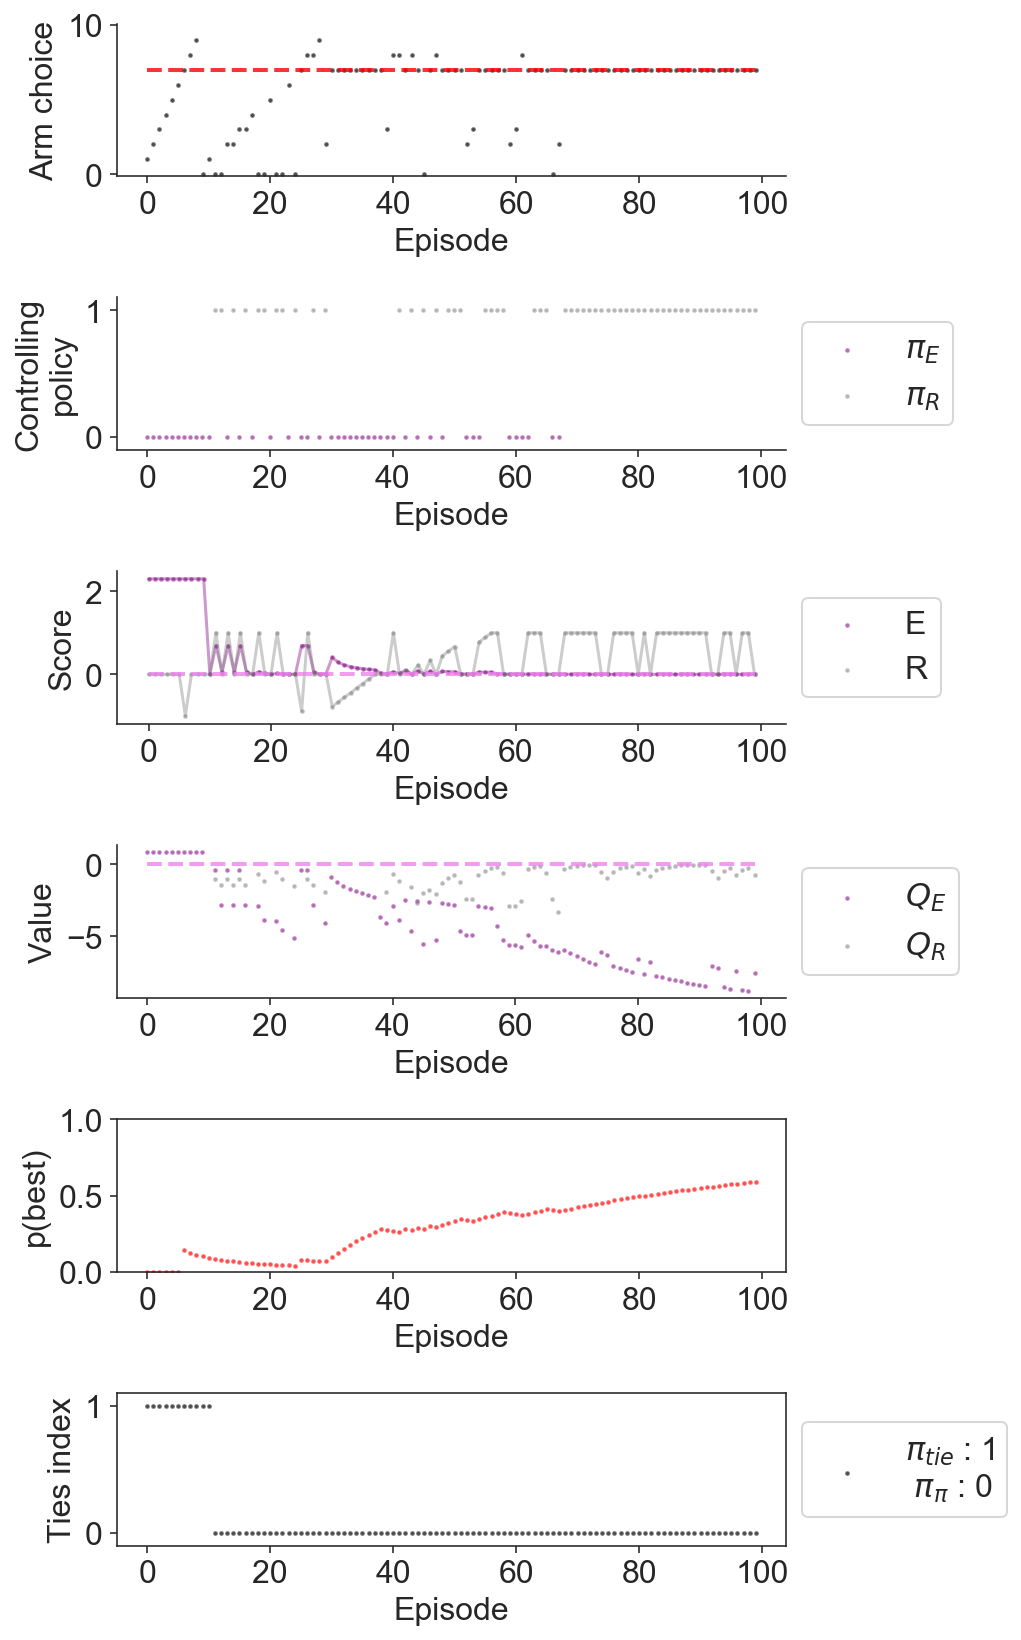

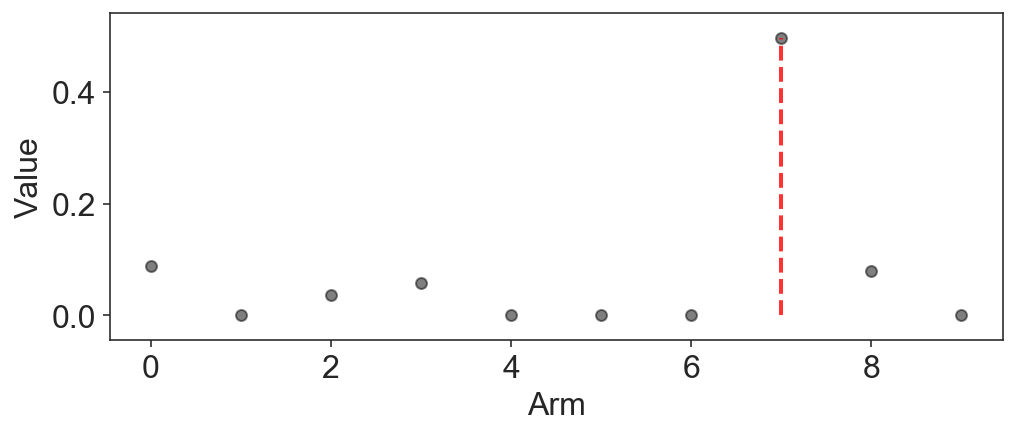

In [85]:
# Pick parameters
lr_R = hp["lr_R"][2]
tie_threshold = hp["tie_threshold"][2]

print(f"Running - lr_R: {lr_R}, tie_threshold: {tie_threshold}")

# Run the exp, and plot its results
result = meta_bandit(
    env_name=env_name,
    num_episodes=100, 
    lr_R=lr_R,
    tie_threshold=tie_threshold,
    seed_value=None,
)

plot_meta(env_name, result, tie_threshold)
plot_critic('critic_R', env_name, result)

## Softbeta

Env - BanditUniform121-v0
Running - lr_R: 0.26851038027162216, beta: 1.2370968119778325, temp: 0.10249880697252074
Best arm: [54], last arm: 54


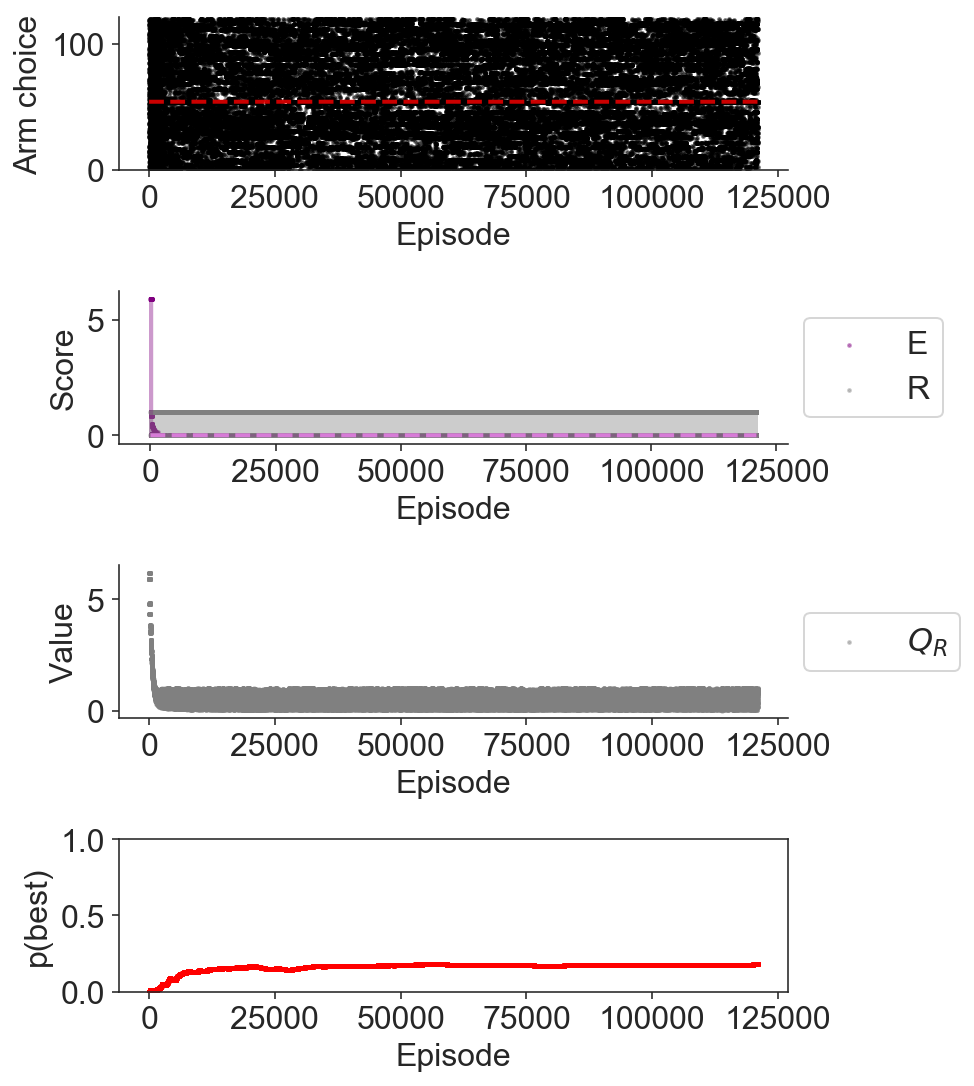

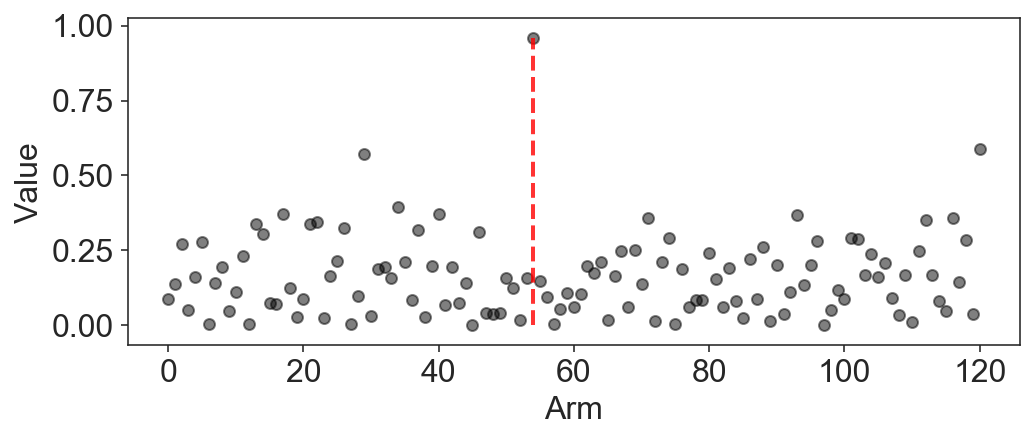

In [111]:
# Pick parameters
lr_R = hp["lr_R"][1]
beta = hp["beta"][1]
temp = hp["temp"][1]

print(f"Env - {env_name}")
print(f"Running - lr_R: {lr_R}, beta: {beta}, temp: {temp}")

# Run the exp, and plot its results
result = softbeta_bandit(
    env_name=env_name,
    num_episodes=2*60500, 
    lr_R=lr_R,
    beta=beta,
    temp=temp,
    seed_value=None,
)

plot_beta(env_name, result)
plot_critic('critic', env_name, result)

## Ep

Env - BanditOneHigh10-v0
Running - lr_R: 0.09215460027979548, epsilon: 0.011819781707590713
Best arm: [7], last arm: 7


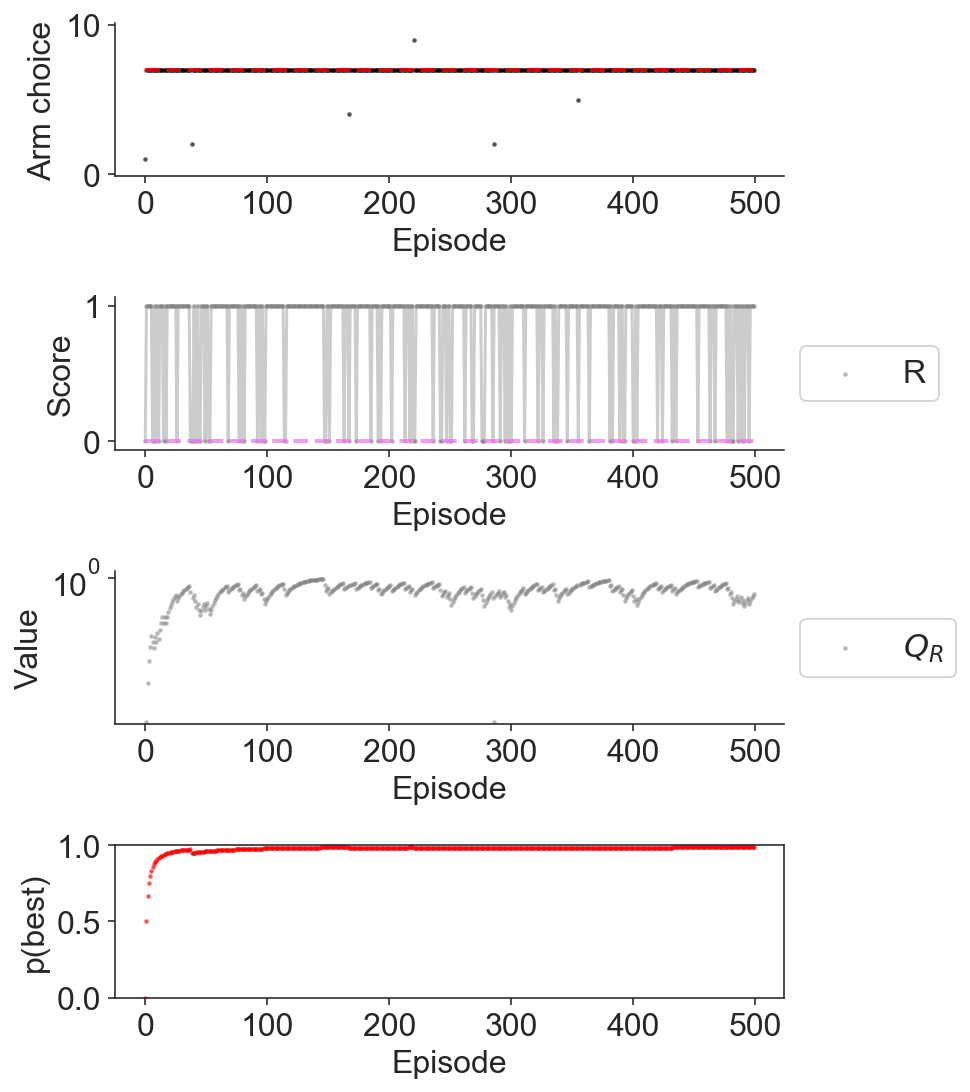

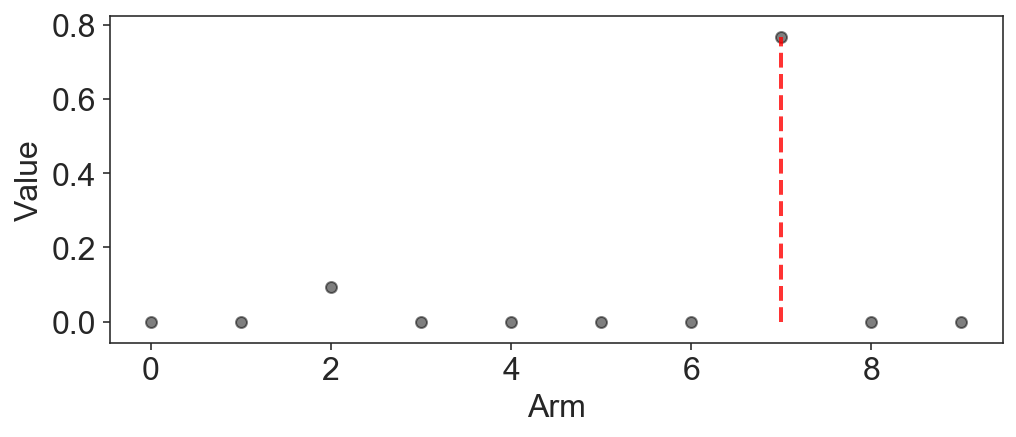

In [146]:
# Pick parameters
lr_R = hp["lr_R"][2]
epsilon = hp["epsilon"][2]

print(f"Env - {env_name}")
print(f"Running - lr_R: {lr_R}, epsilon: {epsilon}")

# Run the exp, and plot its results
result = epsilon_bandit(
    env_name=env_name,
    num_episodes=500, 
    lr_R=lr_R,
    epsilon=epsilon,
    seed_value=None,
)

plot_epsilon(env_name, result)
plot_critic('critic_R', env_name, result)

# Annealed ep

Env - BanditOneHigh10-v0
Running - lr_R: 0.31974857377884874, epsilon: 0.28844806547447577, temp: 0.048166433261047116
Best arm: [7], last arm: 7


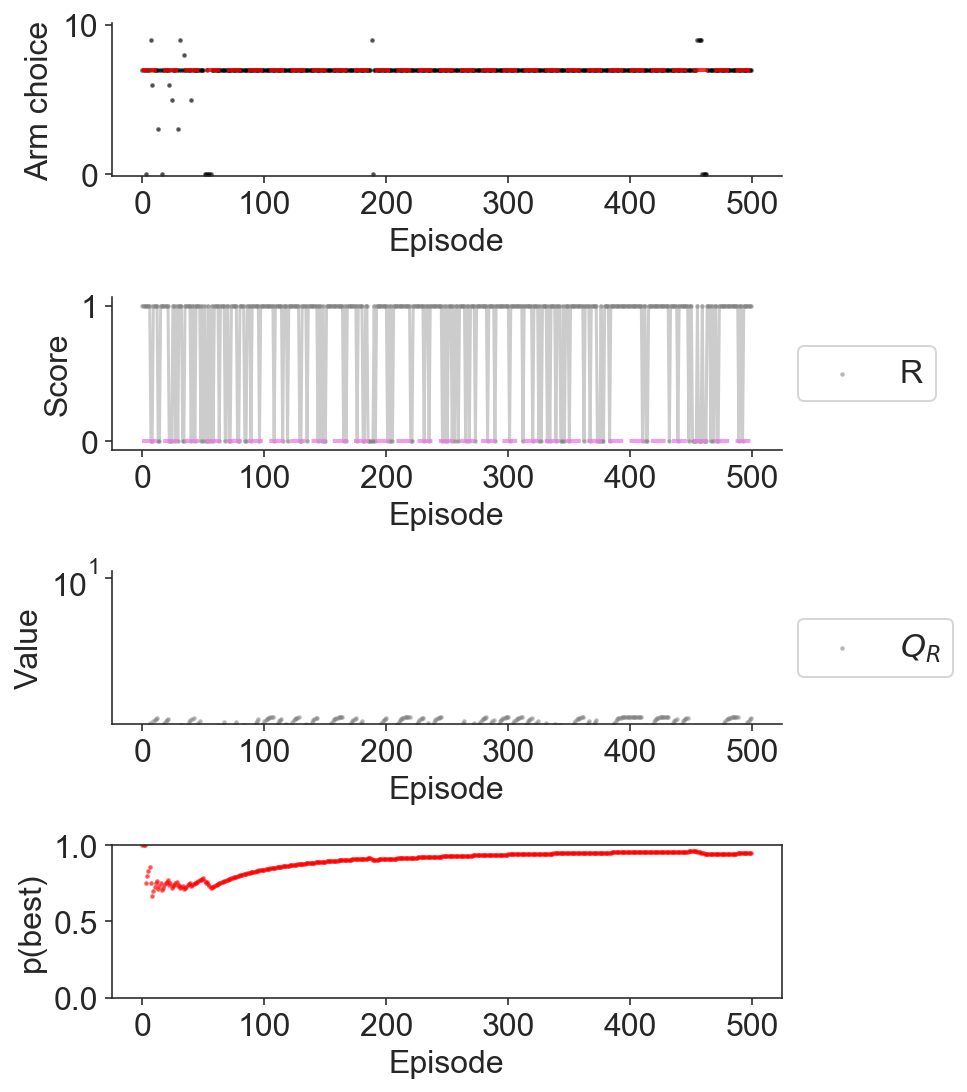

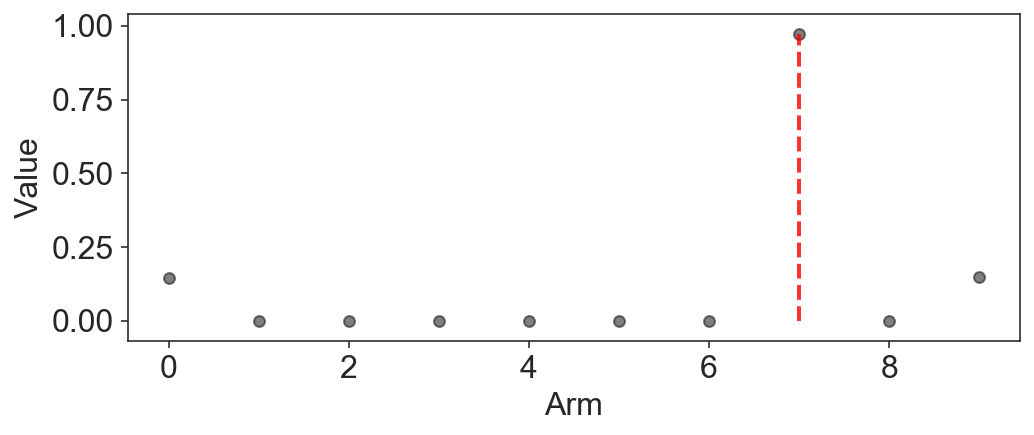

In [162]:
# Pick parameters
lr_R = hp["lr_R"][1]
epsilon = hp["epsilon"][1]
epsilon_decay_tau = hp["epsilon_decay_tau"][1]

print(f"Env - {env_name}")
print(f"Running - lr_R: {lr_R}, epsilon: {epsilon}, temp: {epsilon_decay_tau}")

# Run the exp, and plot its results
result = epsilon_bandit(
    env_name=env_name,
    num_episodes=500, 
    lr_R=lr_R,
    epsilon=epsilon,
    epsilon_decay_tau=epsilon_decay_tau,
    seed_value=None,
)

plot_epsilon(env_name, result)
plot_critic('critic_R', env_name, result)